## Importing the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import requests
import pickle

from warnings import filterwarnings
filterwarnings('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Cleaning & Preparation

In [ ]:
df = pd.read_csv('../data/water_potability.csv')
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   hardness         3276 non-null   float64
 2   solids           3276 non-null   float64
 3   chloramines      3276 non-null   float64
 4   sulfate          2495 non-null   float64
 5   conductivity     3276 non-null   float64
 6   organic_carbon   3276 non-null   float64
 7   trihalomethanes  3114 non-null   float64
 8   turbidity        3276 non-null   float64
 9   potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
numerical_cols = ['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity']
# numerical_cols

In [5]:
df.isna().sum()

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
potability           0
dtype: int64

In [6]:
num_rows_with_nan = df.isna().any(axis=1).sum()
num_rows_with_nan

1265

In [7]:
df.potability.value_counts()

0    1998
1    1278
Name: potability, dtype: int64

In [8]:
# delete the rows with nan
df = df.dropna()
len(df) # current no of rows

2011

In [9]:
df.isna().sum()

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
potability         0
dtype: int64

In [10]:
df.potability.value_counts()

0    1200
1     811
Name: potability, dtype: int64

## Setting up the Validation Framework
- splitting the dataset into train(80%), val(20%) & test(20%)

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=28)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(1206, 402, 403)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = df_train.potability.values
y_val = df_val.potability.values
y_test = df_test.potability.values

In [14]:
df_train = df_train.drop('potability', axis=1)
df_val = df_val.drop('potability', axis=1)
df_test = df_test.drop('potability', axis=1)

In [15]:
df_train.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

In [16]:
df_val.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

In [17]:
df_test.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

## EDA

In [18]:
df_full_train.potability.value_counts()

0    938
1    670
Name: potability, dtype: int64

In [19]:
df_full_train.describe()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
count,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000
mean,7.084363,196.034660,21869.071633,7.131216,333.371535,426.552608,14.369832,66.433782,3.968765,0.416667
std,1.540540,32.564690,8699.408979,1.551356,41.473798,79.848767,3.348989,15.994332,0.785321,0.493160
min,0.989912,73.492234,320.942611,1.920271,129.000000,201.619737,4.371899,14.343161,1.450000,0.000000
25%,6.125570,176.864143,15650.997813,6.138161,307.661233,367.892108,12.128374,56.394805,3.440832,0.000000
50%,7.029490,197.433707,20860.547858,7.138343,332.762592,422.452269,14.351483,66.605160,3.986736,0.000000
75%,8.017427,215.978776,27049.963941,8.087682,359.330449,482.370371,16.704308,77.363344,4.516050,1.000000
max,14.000000,317.338124,56488.672413,13.127000,481.030642,753.342620,27.006707,124.000000,6.494749,1.000000


### Mutual Information

In [20]:
def mutual_info_potability_score(series):
    return mutual_info_score(series, df_full_train.potability)

In [21]:
mi = df_full_train[numerical_cols].apply(mutual_info_potability_score)
mi.sort_values(ascending=False) # most important variable has high mi

ph                 0.679193
hardness           0.679193
solids             0.679193
chloramines        0.679193
sulfate            0.679193
conductivity       0.679193
organic_carbon     0.679193
trihalomethanes    0.679193
turbidity          0.679193
dtype: float64

### Correlation

In [22]:
corr = df_full_train[numerical_cols].corrwith(df_full_train.potability)
corr.sort_values(ascending=False)

solids             0.045847
turbidity          0.018883
chloramines        0.017848
trihalomethanes    0.016589
ph                 0.008764
conductivity      -0.008394
sulfate           -0.010299
hardness          -0.016527
organic_carbon    -0.029939
dtype: float64

### Univariate Analysis
- observe the distribution and transform it if needed

Text(0, 0.5, 'Probability Density')

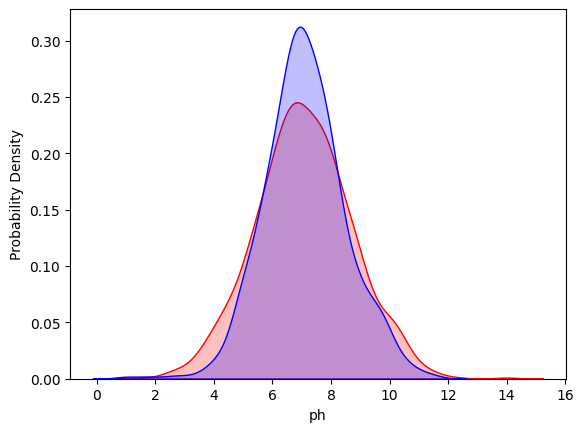

In [23]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'ph'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'ph'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('ph')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

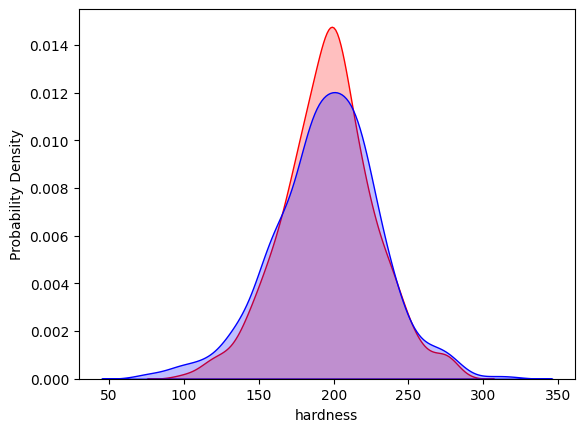

In [24]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'hardness'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'hardness'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('hardness')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

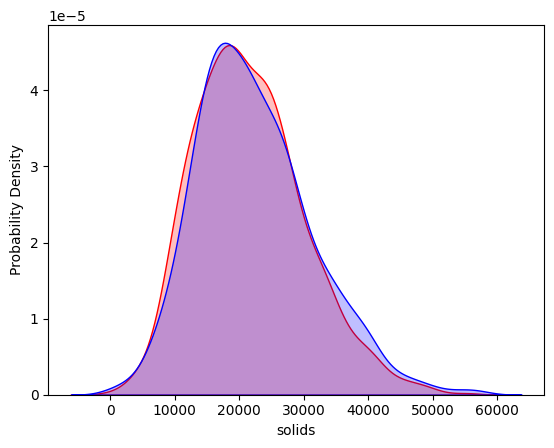

In [25]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'solids'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'solids'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('solids')
plt.ylabel('Probability Density')
#

Text(0, 0.5, 'Probability Density')

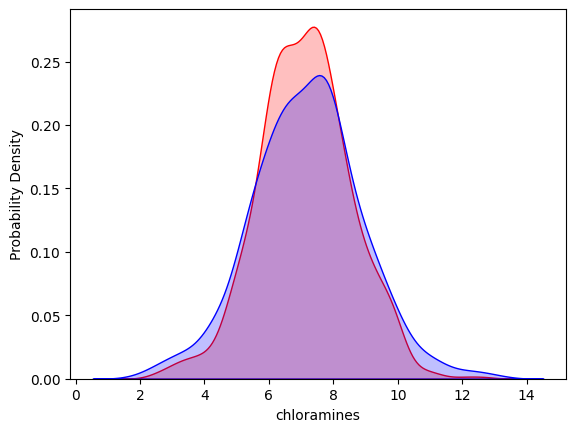

In [26]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'chloramines'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'chloramines'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('chloramines')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

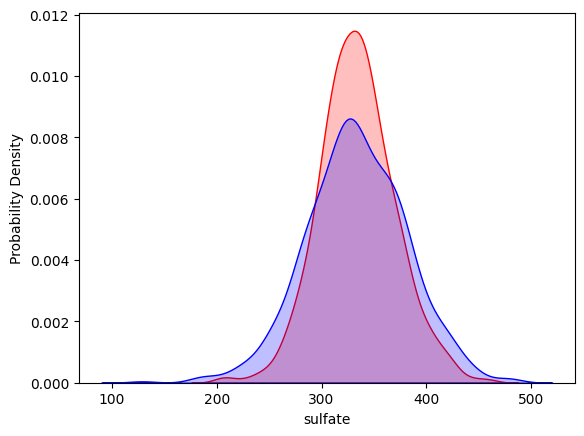

In [27]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'sulfate'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'sulfate'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('sulfate')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

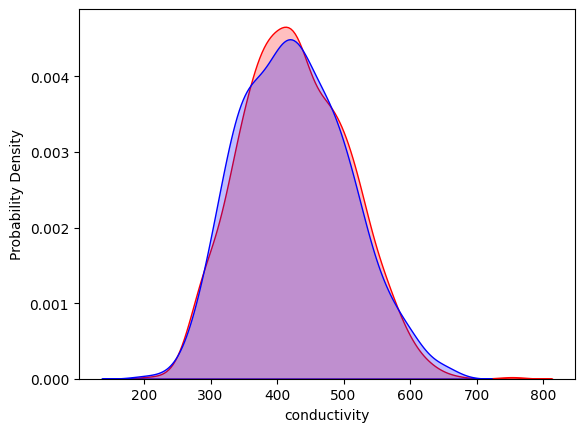

In [28]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'conductivity'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'conductivity'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('conductivity')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

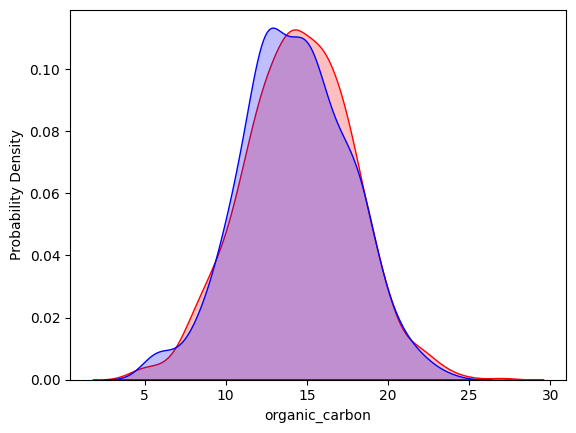

In [29]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'organic_carbon'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'organic_carbon'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('organic_carbon')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

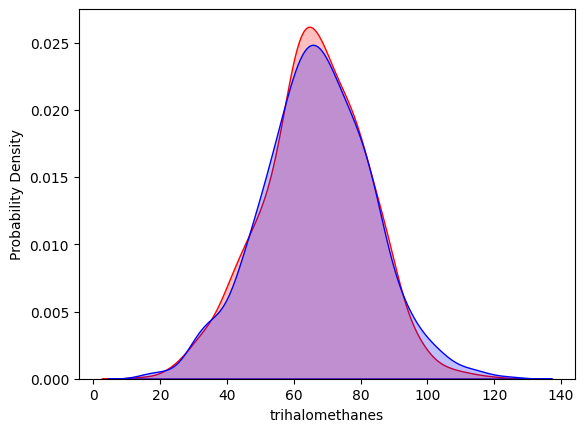

In [30]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'trihalomethanes'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'trihalomethanes'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('trihalomethanes')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

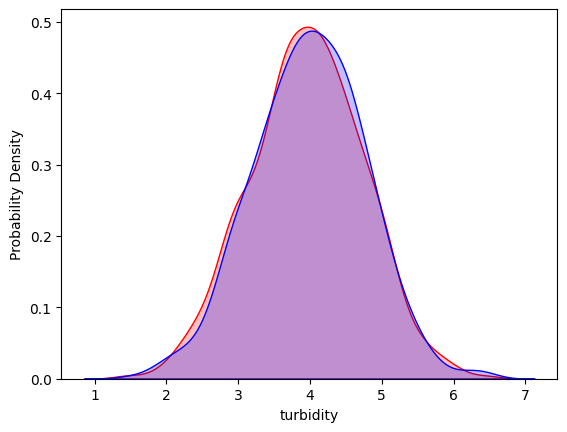

In [31]:
sns.kdeplot(df_full_train.loc[(df_full_train['potability']==0),'turbidity'],
            color='r', shade=True, label='Potability - 0')

sns.kdeplot(df_full_train.loc[(df_full_train['potability']==1),'turbidity'],
            color='b', shade=True, label='Potability - 1')

plt.xlabel('turbidity')
plt.ylabel('Probability Density')

In [32]:
# all the distributions are normal and not skewed
# hence not removing any outliers from any feature

### Bivariate Analysis

In [33]:
# scatter plots between each feature and target feature, potability
sns.pairplot(df_full_train, hue='potability')

<AxesSubplot: >

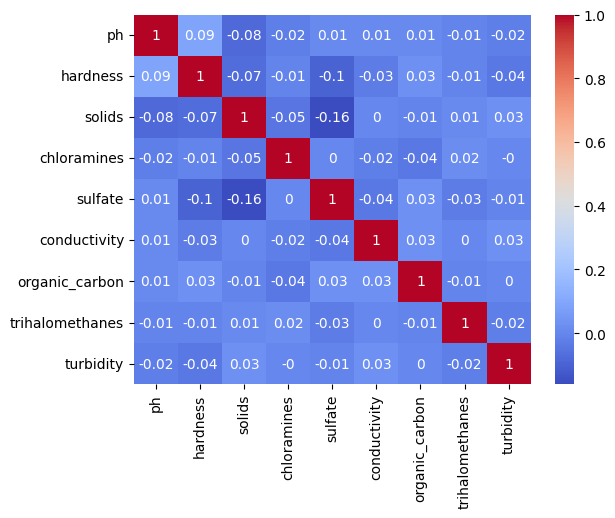

In [34]:
sns.heatmap(df_full_train[numerical_cols].corr().round(2), annot=True, cmap='coolwarm')

In [35]:
# no 2 features are correlated to each other, all are independent

## Training and Evaluating with Logistic Regression

In [36]:
model0 = LogisticRegression()
model0.fit(df_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [37]:
# model0.predict_proba(df_val)[:,1]
y_pred = model0.predict(df_val)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
# Accuracy of model0
round(accuracy_score(y_pred, y_val),3)

0.632

In [39]:
round(roc_auc_score(y_val, y_pred),3)

0.503

In [40]:
# finding the threshold probability
y_pred = model0.predict_proba(df_val)[:,1]
decision = y_pred >= 0.6
round((y_val == decision).mean(),3)
# 0.6

0.637

In [41]:
## hyperparameter tuning
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for c in C:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=28)
    model.fit(df_train, y_train)

    y_pred = model.predict_proba(df_val)[:,1]
    decision = y_pred >= 0.6

    acc = round(accuracy_score(decision, y_val),3)
    print(c, acc)

0.0001 0.637
0.001 0.637
0.01 0.637
0.1 0.637
1 0.637
10 0.637
100 0.637


In [42]:
model1 = LogisticRegression(solver='liblinear', C=0.0001, max_iter=1000, random_state=28)
model1.fit(df_train, y_train)
y_pred = model.predict_proba(df_val)[:,1]
decision = y_pred >= 0.6

round(accuracy_score(decision, y_val),3)

0.637

In [43]:
round(roc_auc_score(y_val, y_pred),3)

0.502

In [44]:
precision = precision_score(y_val, decision, average='weighted') 
recall = recall_score(y_val, decision, average='weighted') 
f1 = f1_score(y_val, decision, average='weighted')
print(f'Precision: {round(precision,3)}, Recall: {round(recall,3)}, F1 Score: {round(f1,3)}')

Precision: 0.406, Recall: 0.637, F1 Score: 0.496


In [45]:
def train(df_train, y_train, C=0.001):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(df_train, y_train)
    return model

def predict_prob(df_val, model):
    y_prob = model.predict_proba(df_val)[:, 1]
    return y_prob

def predict(df_val, model):
    y_pred = model.predict(df_val)
    return y_pred

In [46]:
for C in tqdm([0.0001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=28)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train1 = df_full_train.iloc[train_idx]
        df_val1 = df_full_train.iloc[val_idx]

        y_train1 = df_train1.potability.values
        y_val1 = df_val1.potability.values

        model = train(df_train1, y_train1, C=C)
        y_pred1 = predict_prob(df_val1, model)

        auc = roc_auc_score(y_val1, y_pred1)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 45.88it/s]

C=0.0001 0.560 +- 0.027
C=0.001 0.941 +- 0.027
C=1 1.000 +- 0.000


## Training and Evaluating with Decision Tree Classifier

In [47]:
df_train.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

In [48]:
train_dicts = df_train.to_dict(orient='records')

In [49]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[  6.90720282, 448.66642331, 210.73412392, ..., 319.88695657,
        124.        ,   2.85376735],
       [  7.36501509, 340.80882275, 200.13982872, ..., 409.44672985,
         72.73063948,   3.82309268],
       [  6.83293827, 421.22022804, 154.68190227, ..., 290.70323629,
         65.89139218,   3.38970529],
       ...,
       [  5.78335739, 380.42841471, 192.64884626, ..., 282.9698785 ,
         80.49849792,   4.45352556],
       [  7.71692292, 356.18191586, 223.77266132, ..., 281.11849035,
         84.01358459,   4.73684958],
       [  7.30644732, 257.00771769, 198.49315623, ..., 335.48219374,
         52.86038799,   3.27558118]])

In [50]:
model2 = DecisionTreeClassifier(max_depth=4)
model2.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [51]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_val

array([[  6.90037965, 210.31918197, 199.35316553, ..., 304.96648814,
         62.84667263,   3.69887477],
       [  4.86847999, 414.42701672, 146.86567979, ..., 320.01237162,
         84.40368411,   4.28131346],
       [  5.38924862, 516.28408286, 181.93812565, ..., 390.59639198,
         58.24173419,   4.28894682],
       ...,
       [  5.69007827, 573.81474365, 143.29995945, ..., 338.89719989,
         48.97388657,   3.39904791],
       [  8.26797411, 286.89077676, 145.27770635, ..., 341.4774736 ,
         42.28905418,   4.71416345],
       [  6.51098011, 444.84358403, 154.54694875, ..., 419.21630452,
         49.51517499,   3.26640974]])

In [52]:
y_pred = model2.predict(X_val)
round(accuracy_score(y_val, y_pred),3)

0.667

In [53]:
round(roc_auc_score(y_val, y_pred),3)

0.576

In [54]:
print(export_text(model2, feature_names=dv.get_feature_names_out()))

|--- sulfate <= 259.27
|   |--- solids <= 19218.71
|   |   |--- ph <= 7.95
|   |   |   |--- turbidity <= 4.68
|   |   |   |   |--- class: 0
|   |   |   |--- turbidity >  4.68
|   |   |   |   |--- class: 1
|   |   |--- ph >  7.95
|   |   |   |--- class: 1
|   |--- solids >  19218.71
|   |   |--- conductivity <= 276.61
|   |   |   |--- class: 0
|   |   |--- conductivity >  276.61
|   |   |   |--- conductivity <= 555.35
|   |   |   |   |--- class: 1
|   |   |   |--- conductivity >  555.35
|   |   |   |   |--- class: 0
|--- sulfate >  259.27
|   |--- sulfate <= 363.47
|   |   |--- ph <= 4.81
|   |   |   |--- trihalomethanes <= 35.03
|   |   |   |   |--- class: 1
|   |   |   |--- trihalomethanes >  35.03
|   |   |   |   |--- class: 0
|   |   |--- ph >  4.81
|   |   |   |--- hardness <= 112.93
|   |   |   |   |--- class: 1
|   |   |   |--- hardness >  112.93
|   |   |   |   |--- class: 0
|   |--- sulfate >  363.47
|   |   |--- ph <= 7.79
|   |   |   |--- hardness <= 197.96
|   |   |   |   |-

In [55]:
## hyperparameter tuning
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.502
   2 -> 0.532
   3 -> 0.576
   4 -> 0.581
   5 -> 0.590
   6 -> 0.640
  10 -> 0.592
  15 -> 0.590
  20 -> 0.554
None -> 0.559


In [56]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [57]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [58]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.576  0.591  0.638
5                 0.576  0.578  0.620
10                0.576  0.561  0.594
15                0.576  0.556  0.578
20                0.578  0.568  0.590
100               0.561  0.605  0.605
200               0.572  0.572  0.572
500               0.500  0.500  0.500

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

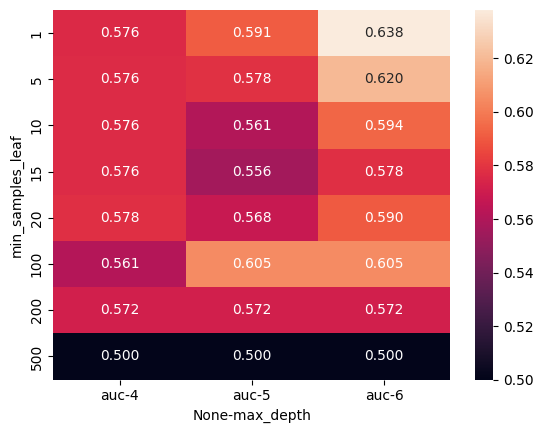

In [59]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [60]:
model3 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
model3.fit(X_train, y_train)

y_pred = dt.predict(X_val)
auc = roc_auc_score(y_val, y_pred)
print(round(accuracy_score(y_pred, y_val),3))

0.612


In [61]:
round(roc_auc_score(y_val, y_pred),3)

0.572

In [62]:
print(export_text(model3, feature_names=list(dv.get_feature_names_out())))

|--- sulfate <= 259.27
|   |--- solids <= 27954.17
|   |   |--- class: 1
|   |--- solids >  27954.17
|   |   |--- class: 1
|--- sulfate >  259.27
|   |--- sulfate <= 363.47
|   |   |--- ph <= 4.81
|   |   |   |--- sulfate <= 313.84
|   |   |   |   |--- class: 0
|   |   |   |--- sulfate >  313.84
|   |   |   |   |--- class: 0
|   |   |--- ph >  4.81
|   |   |   |--- solids <= 34961.42
|   |   |   |   |--- trihalomethanes <= 92.01
|   |   |   |   |   |--- ph <= 9.87
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ph >  9.87
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- trihalomethanes >  92.01
|   |   |   |   |   |--- class: 1
|   |   |   |--- solids >  34961.42
|   |   |   |   |--- ph <= 6.97
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ph >  6.97
|   |   |   |   |   |--- class: 1
|   |--- sulfate >  363.47
|   |   |--- ph <= 7.79
|   |   |   |--- hardness <= 197.96
|   |   |   |   |--- turbidity <= 4.29
|   |   |   |   |   |--- ph <= 6.77
|   |   |

## Training and Evaluating with Random Forests Classifier

In [63]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
sparse_matrix = dv.fit_transform(train_dicts)
feature_names = dv.get_feature_names_out()
print(feature_names)

['chloramines' 'conductivity' 'hardness' 'organic_carbon' 'ph' 'solids'
 'sulfate' 'trihalomethanes' 'turbidity']


In [64]:
X_train = sparse_matrix.toarray()
X_train

array([[  6.90720282, 448.66642331, 210.73412392, ..., 319.88695657,
        124.        ,   2.85376735],
       [  7.36501509, 340.80882275, 200.13982872, ..., 409.44672985,
         72.73063948,   3.82309268],
       [  6.83293827, 421.22022804, 154.68190227, ..., 290.70323629,
         65.89139218,   3.38970529],
       ...,
       [  5.78335739, 380.42841471, 192.64884626, ..., 282.9698785 ,
         80.49849792,   4.45352556],
       [  7.71692292, 356.18191586, 223.77266132, ..., 281.11849035,
         84.01358459,   4.73684958],
       [  7.30644732, 257.00771769, 198.49315623, ..., 335.48219374,
         52.86038799,   3.27558118]])

In [65]:
model4 = RandomForestClassifier(n_estimators=40, random_state=28, n_jobs=-1)
model4.fit(X_train, y_train)

,n_estimators,40
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_val = X_val.toarray()
y_pred = model4.predict(X_val)

In [67]:
round(accuracy_score(y_pred, y_val),3)

0.634

In [68]:
round(roc_auc_score(y_val, y_pred),3)

0.585

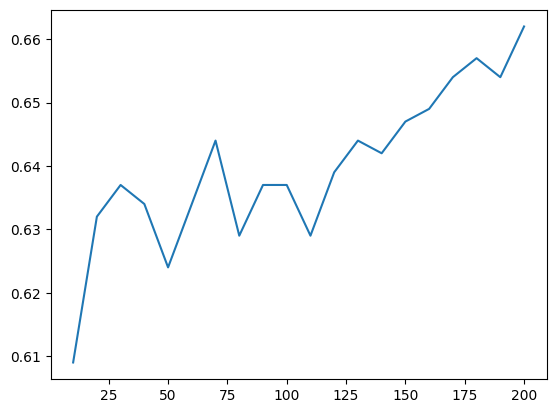

In [69]:
## hyperparameter tuning
# select the best n_estimators : 150
scores = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=28)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append([i, round(accuracy_score(y_val, y_pred),3)])

df_scores = pd.DataFrame(scores)
# df_scores
plt.plot(df_scores[0], df_scores[1])

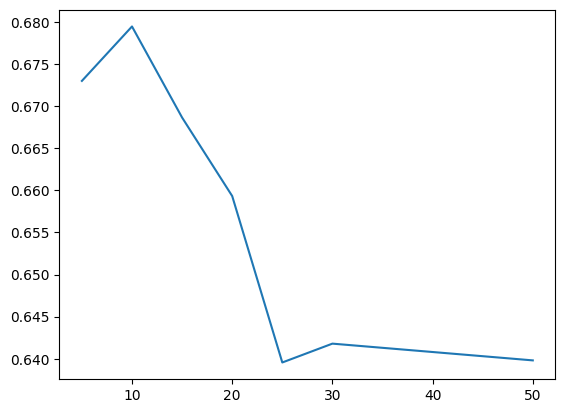

In [70]:
# select the best max_depth : 10
scores = []
for i in [5, 10, 15, 20, 25, 30, 50]:
    acc = []
    for j in range(10, 201, 10):
        rf = RandomForestClassifier(max_depth=i, n_estimators=j, random_state=28)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        acc.append(accuracy_score(y_val, y_pred))
    scores.append([i, np.mean(acc)])

df_scores = pd.DataFrame(scores)
# df_scores
plt.plot(df_scores[0], df_scores[1])

In [71]:
model5 = RandomForestClassifier(max_depth=10, n_estimators=150, random_state=28, n_jobs=-1)
model5.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_val = X_val.toarray()
y_pred = model4.predict(X_val)
round(accuracy_score(y_pred, y_val),3)

0.634

In [73]:
round(roc_auc_score(y_val, y_pred),3)

0.585

In [74]:
model5.feature_importances_

array([0.11336968, 0.08087909, 0.10883368, 0.07989231, 0.16803539,
       0.10683365, 0.18171395, 0.08362479, 0.07681746])

In [75]:
# feature importance of each
s = pd.Series(model5.feature_importances_, index=df_train.columns)
s.sort_values(ascending=False)

organic_carbon     0.181714
sulfate            0.168035
ph                 0.113370
solids             0.108834
conductivity       0.106834
trihalomethanes    0.083625
hardness           0.080879
chloramines        0.079892
turbidity          0.076817
dtype: float64

## Training and Evaluating with Gradient Boosting (XGBoost)

In [76]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [77]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model6 = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [79]:
s = output.stdout

In [80]:
print(s[:200])

[0]	train-auc:0.71657	val-auc:0.61356
[5]	train-auc:0.85438	val-auc:0.65917
[10]	train-auc:0.86545	val-auc:0.66551
[15]	train-auc:0.88766	val-auc:0.67351
[20]	train-auc:0.91251	val-auc:0.65980
[25]	tr


In [81]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [82]:
df_score = parse_xgb_output(output)

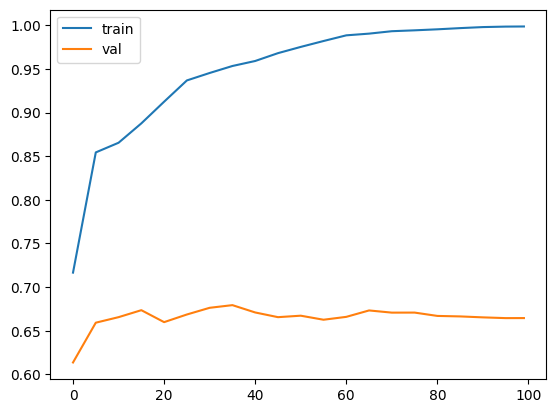

In [83]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

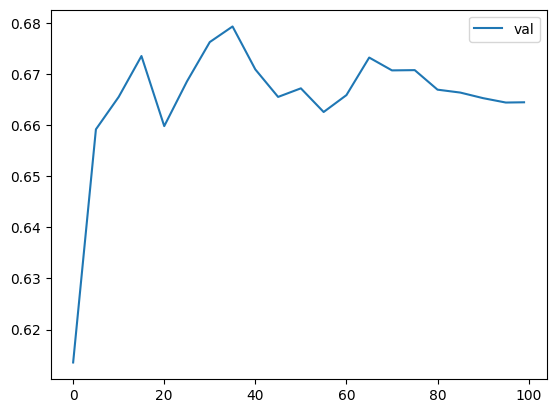

In [84]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [85]:
## hyperparameter tuning
# eta, max_depth, min_child_weight

In [86]:
# eta
scores = {}

In [87]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [88]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
scores.keys()
# dict_keys(['max_depth=4', 'max_depth=5', 'max_depth=6', 'max_depth=7', 'max_depth=8', 'max_depth=9', 'max_depth=10', 'eta=0.05'])

dict_keys(['eta=0.05'])

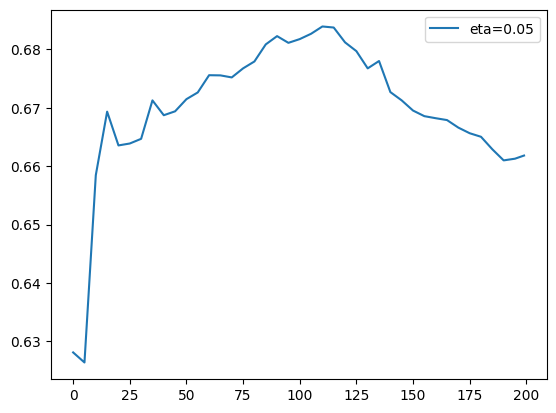

In [89]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
# 1.0

In [90]:
# max_depth
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 25,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
scores.keys()
# dict_keys(['max_depth=4', 'max_depth=5', 'max_depth=6', 'max_depth=7', 'max_depth=8', 'max_depth=9', 'max_depth=10', 'max_depth=25'])

dict_keys(['max_depth=25'])

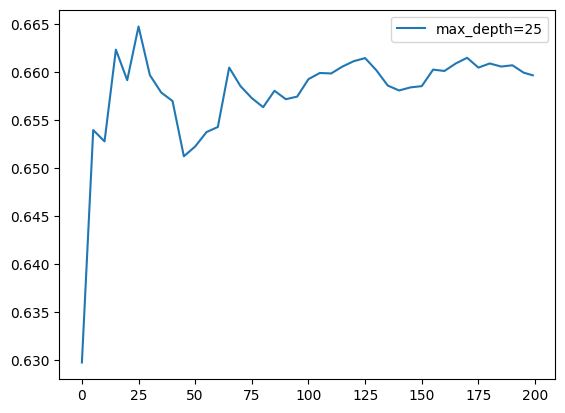

In [93]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
# 10

In [94]:
# min_child_weight
scores = {}

In [95]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 10,
    'min_child_weight': 20,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [96]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
scores.keys()
# dict_keys(['min_child_weight=1', 'min_child_weight=3', 'min_child_weight=10', 'min_child_weight=30', 'min_child_weight=20'])

dict_keys(['min_child_weight=20'])

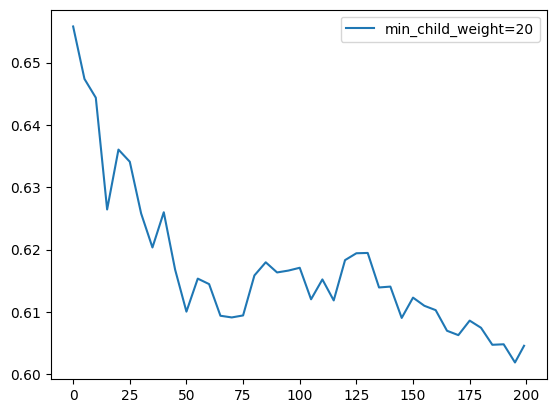

In [97]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
# 3

In [98]:
# final params
xgb_params = {
    'eta': 1.0, 
    'max_depth': 10,
    'min_child_weight': 3,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model7 = xgb.train(xgb_params, dtrain, num_boost_round=30,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.79971	val-auc:0.62186
[5]	train-auc:0.98390	val-auc:0.62551
[10]	train-auc:0.99977	val-auc:0.62610
[15]	train-auc:1.00000	val-auc:0.61473
[20]	train-auc:1.00000	val-auc:0.62166
[25]	train-auc:1.00000	val-auc:0.61478
[29]	train-auc:1.00000	val-auc:0.62013


In [99]:
y_pred = model7.predict(dval)

In [100]:
round(roc_auc_score(y_val, y_pred),3)

0.62

## Selecting the Final Model

In [101]:
df_full_train = df_full_train.reset_index(drop=True)

In [102]:
y_full_train = df_full_train.potability.values

In [103]:
df_full_train = df_full_train.drop('potability', axis=1)

In [104]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [105]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [106]:
xgb_params = {
    'eta': 1.0, 
    'max_depth': 10,
    'min_child_weight': 3,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_final = xgb.train(xgb_params, dtrain, num_boost_round=30)

In [107]:
y_pred = model_final.predict(dtest)
round(roc_auc_score(y_test, y_pred))

1

## Saving & Loading the Model

In [108]:
output_file0 = f'final_model_prob.bin'

In [109]:
with open(output_file0, 'wb') as f_out:
    pickle.dump((dv,model_final), f_out)

In [110]:
with open(output_file0, 'rb') as f_in:
    dv8, model8 = pickle.load(f_in)

In [111]:
# 0
water_sample0 = {
    'ph': 5.5,
    'hardness': 207,
    'solids': 44612,
    'chloramines': 7.0,
    'sulfate': 300,
    'conductivity': 553,
    'organic_carbon': 10,
    'trihalomethanes': 50,
    'turbidity': 3
}

water_sample1 = {
    'ph': 8.3,
    'hardness': 183.6,
    'solids': 20316,
    'chloramines': 7.0,
    'sulfate': 322,
    'conductivity': 295,
    'organic_carbon': 13,
    'trihalomethanes': 62.4,
    'turbidity': 4.2
}

In [112]:
X = dv8.transform(water_sample0)
dX = xgb.DMatrix(X, feature_names=dv.get_feature_names_out())
print(model8.predict(dX)[0])

0.007542403


In [113]:
X = dv8.transform(water_sample1)
dX = xgb.DMatrix(X, feature_names=dv.get_feature_names_out())
model8.predict(dX)[0]

0.504865

In [114]:
# if prob>=0.5:
#     print('Potable')
# else:
#     print('Not Potable')